Developing an LSTM model to predict future stock prices involves several steps. 
These steps include data preprocessing, model building, hyperparameter tuning, and evaluation. 

Below, I'll outline the steps and provide code snippets for each part.


Check for varying Timeframe (50 Years - 20 Years - 10 years )

First, we need to collect and preprocess the historical stock price data. 

This typically involves normalizing the data and creating sequences for the LSTM model.

"Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
# Load data
# Added data since 1974-01-01

data = pd.read_csv('stocks_data.csv', index_col = 0)
data.head(2)

,Date,BA,DE,MSI,SPGI
0,1974-01-02,0.130799,1.094406,2.354811,0.191056
1,1974-01-03,0.132121,1.148318,2.440219,0.200771


In [4]:
data['Date']

0        1974-01-02
1        1974-01-03
2        1974-01-04
3        1974-01-07
4        1974-01-08
            ...    
12604    2023-12-22
12605    2023-12-26
12606    2023-12-27
12607    2023-12-28
12608    2023-12-29
Name: Date, Length: 12609, dtype: object

In [5]:
# Assuming the data has a 'Date' column and 'Close' price column
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [6]:
data.head(2)

,BA,DE,MSI,SPGI
Date,,,,
1974-01-02,0.130799,1.094406,2.354811,0.191056
1974-01-03,0.132121,1.148318,2.440219,0.200771


Checking for one by one Stocks, starting with BA.

In [7]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['DE'].values.reshape(-1, 1))

In [8]:
scaled_data

array([[0.00107148],
       [0.00119424],
       [0.0011083 ],
       ...,
       [0.90290646],
       [0.90084999],
       [0.90222843]])

In time series forecasting, particularly with LSTM models, a "window" refers to a sequence of consecutive time points used as input to predict future values. A 60-day window means we are using the stock prices from the past 60 days to predict the stock price on the 61st day. This approach captures temporal dependencies and patterns in the data, which are crucial for making accurate predictions.

The choice of a 60-day window (or sequence length) in time series forecasting, particularly for stock price prediction using LSTM models, is based on several considerations:

- Historical Trends and Patterns: Stock prices often exhibit trends, cycles, and patterns over time. A 60-day window allows the model to capture these medium-term patterns, such as monthly trends, which are significant for making predictions.

- Balance Between Data Availability and Model Complexity: A longer sequence provides more historical context to the model, potentially improving its ability to learn patterns. However, too long a sequence can increase the model complexity and computational requirements, and might also lead to overfitting. A 60-day window strikes a balance by providing sufficient historical data without overwhelming the model.

- Empirical Studies and Industry Practice: Many empirical studies and industry practices in financial modeling use a range of 30 to 90 days for sequence lengths. The 60-day window is a common and practical choice within this range.

- Market Behavior: Stock markets often show significant changes within a 60-day period due to quarterly earnings reports, economic data releases, and other macroeconomic events. Capturing these dynamics can be beneficial for prediction accuracy.

In [9]:

# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)



In [10]:
sequence_length = 60  # 60 days look back
X, y = create_sequences(scaled_data, sequence_length)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
len(y_train)

10039

In [12]:
data.shape

(12609, 4)

In [13]:
len(y_test)

2510

In [14]:
len(X_train[0])

60

In [15]:
len(X_train)

10039

Build LSTM Model

In [16]:
def build_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

To find the best combination of hyperparameters, we can use Keras Tuner or a custom grid search.



Choosing a minimum value of 50 instead of 10 for hp_units likely reflects a balance between computational efficiency and model complexity, as well as practical considerations based on the specific problem. Here's why a minimum value of 50 might be preferred over 10:

- Sufficient Model Capacity:

A minimum value of 50 units ensures that the model has enough capacity to capture meaningful patterns in the data. In many practical scenarios, 10 units might be insufficient, leading to underfitting where the model fails to learn the underlying data distribution effectively.
Avoiding Underfitting:

With only 10 units, the model might be too simplistic, especially for complex datasets. This could result in poor performance because the model cannot adequately represent the complexity of the data.
Empirical Evidence:

Often, hyperparameter ranges are informed by empirical evidence and prior experiments. If past experiments or domain knowledge suggest that configurations with fewer than 50 units generally perform poorly, it makes sense to set the lower bound at 50.

- Computational Efficiency:

Exploring configurations with very low units (like 10, 20, 30) may not be an efficient use of computational resources if these configurations are likely to perform poorly. Starting at 50 helps focus the search on more promising areas of the hyperparameter space.
Practical Experience:

Practical experience with similar models or datasets might indicate that starting with 50 units is a reasonable baseline that balances model complexity and training time. It avoids the pitfalls of too small networks while not being overly complex.

- Step Size Consideration:

Given a step size of 50, starting from 10 would result in a sequence of (10, 60, 110, 160, 210). This is less intuitive and potentially less useful than (50, 100, 150, 200), where each step represents a significant and meaningful increase in model capacity.
Search Space Efficiency:

Hyperparameter tuning often involves a trade-off between the breadth of the search space and the granularity of the search. By starting at 50 and using a step of 50, you ensure a more focused and manageable search space, improving the likelihood of finding optimal configurations without excessive computational cost.
By setting the minimum value to 50, the tuning process starts with a model complexity that is more likely to be effective, avoiding the inefficiency and potential performance issues associated with very small networks.

In [17]:
from keras_tuner import RandomSearch

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='stock_price_tuning_rs_de',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
50                |50                |units
0.5               |0.5               |dropout_rate
0.001             |0.001             |learning_rate


Epoch 1/50


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/251 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0046

Bayesian Optimization is a probabilistic model-based optimization method that is particularly effective for tuning hyperparameters.

In [ ]:
from keras_tuner import BayesianOptimization

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=3,
    directory='stock_price_tuning_bayesian_de',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

Hyperband is an optimization algorithm that uses adaptive resource allocation and early-stopping to find the best hyperparameters quickly.

In [ ]:
from keras_tuner import Hyperband

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = Hyperband(
    model_builder,
    objective='val_loss',
    max_epochs=50,
    executions_per_trial=3,
    directory='stock_price_tuning_hyperband_de',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Grid Search is an exhaustive search method that evaluates all possible combinations of hyperparameters.

In [ ]:
from keras_tuner import GridSearch

def model_builder(hp):
    model = Sequential()
    hp_units = hp.Int('units', min_value=50, max_value=200, step=50)
    hp_dropout = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(units=hp_units))
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')
    return model

tuner = GridSearch(
    model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='stock_price_tuning_grid_de',
    project_name='stock_price_prediction'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the LSTM layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


c:\Users\SHEKHAR\.conda\envs\aws\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.0062 - val_loss: 4.1631e-04
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 9.9745e-04 - val_loss: 1.4420e-04
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 5.9796e-04 - val_loss: 1.2818e-04
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 6.5519e-04 - val_loss: 3.1991e-04
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 5.6306e-04 - val_loss: 5.9300e-04
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 6.0661e-04 - val_loss: 1.8287e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.4541e-04
Test Loss: 0.00023816539032850415


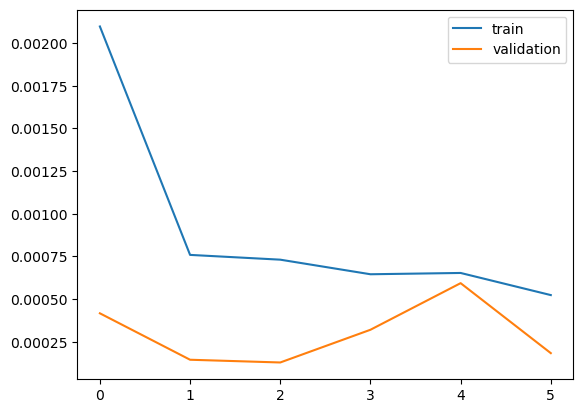

In [ ]:
# Build the model with the optimal hyperparameters
model = build_model(best_hps.get('units'), best_hps.get('dropout_rate'), best_hps.get('learning_rate'))

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


Exploring Different Sequence Lengths


While 60 days is a reasonable starting point, it's essential to experiment with different sequence lengths to determine the optimal window for your specific dataset and model. Here's how you can do that:

In [ ]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)


Experiment with Different Sequence Lengths
You can loop through different sequence lengths to find the best performing one.

In [ ]:
sequence_lengths = [30, 60, 90, 180, 360]
results = {}

for seq_len in sequence_lengths:
    X, y = create_sequences(scaled_data, seq_len)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = build_model(best_hps.get('units'), best_hps.get('dropout_rate'), best_hps.get('learning_rate'))
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    loss = model.evaluate(X_test, y_test)
    results[seq_len] = loss
    print(f'Sequence Length: {seq_len}, Test Loss: {loss}')

# Find the best sequence length
best_seq_len = min(results, key=results.get)
print(f'Best Sequence Length: {best_seq_len}')


Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0042 - val_loss: 6.2516e-04
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 7.3927e-04 - val_loss: 1.4008e-04
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 6.3101e-04 - val_loss: 8.8061e-04
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 6.9391e-04 - val_loss: 9.5487e-05
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 8.8070e-04 - val_loss: 7.5412e-05
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 6.8378e-04 - val_loss: 4.9860e-05
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 6.1379e-04 - val_loss: 1.6740e-04
Epoch 8/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 5.4029e-04 - val_loss: 3.8615e-05
Epoch 9/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 4.9751e-04 - val_loss: 2.5265e-04
Epoch 10/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 6.5435e-04 - val_loss: 1.5929e-04
Epoch 11/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step

Sequence Length: 90, Test Loss: 0.00033690148848108947
Best Sequence Length: 90